In [1]:
import time
import collections
import pickle
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sliding_window import sliding_window
from cluster_eval import greedy_relabel
from cluster_eval import brute_relabel
from cluster_eval import print_results
from cluster_eval import relabel_list
from keras import layers

# Hardcoded length of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_LENGTH = 24

# Hardcoded step of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_STEP = 12

In [29]:
def load_dataset(filename):

    f = open(filename, 'rb')
    data = pickle.load(f)
    f.close()

    X_train, y_train = data[0]
    X_test, y_test = data[1]

    print(" ..from file {}".format(filename))
    print(" ..reading instances: train {0}, test {1}".format(X_train.shape, X_test.shape))

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # The targets are casted to int8 for GPU compatibility.
    y_train = y_train.astype(np.uint8)
    y_test = y_test.astype(np.uint8)

    return X_train, y_train, X_test, y_test

print("Loading data...")
X_train, y_train, X_test, y_test = load_dataset('oppChallenge_locomotion.data')

def remove_class(X_train, y_train, X_test, y_test, class_n):
    uy_train = y_train[y_train != class_n]
    uX_train = X_train[y_train != class_n]
    uy_test = y_test[y_test != class_n]
    uX_test = X_test[y_test != class_n]
    
    classes = set(y_train)
    
    for x in range(class_n + 1, len(classes)):
        uy_train[uy_train == x] = x - 1
        uy_test[uy_test == x] = x - 1
        
    return uX_train, uy_train, uX_test, uy_test

# def delete_features():
# RKN^, RKN_, BACK, HIP, R-SHOE, L-SHOE
# 53 Features

#features_delete = np.arange(6, 15)
#features_delete = np.concatenate([features_delete, np.arange(21, 36)])
#features_delete = np.concatenate([features_delete, np.arange(45, 81)])

# 60 Features
#features_delete = np.arange(0, 6)
#features_delete = np.concatenate([features_delete, np.arange(15, 21)])
#features_delete = np.concatenate([features_delete, np.arange(36, 45)])
#features_delete = np.concatenate([features_delete, np.arange(81, 113)])

# 9 Features (BACK - Phone)
#features_delete = np.arange(0, 36)
#features_delete = np.concatenate([features_delete, np.arange(45, 113)])

# 9 Features (RUA - Phone on Shoulder)
#features_delete = np.arange(0, 45)
#features_delete = np.concatenate([features_delete, np.arange(54, 113)])

# 9 Features (RLA - Wrist Watch)
#features_delete = np.arange(0, 54)
#features_delete = np.concatenate([features_delete, np.arange(63, 113)])

#X_train = np.delete(X_train, features_delete, 1)
#X_test = np.delete(X_test, features_delete, 1)

classes = ["Null", "Stand", "Walk" ,"Sit", "Lie"]

# 0 - null | 1 - stand | 2 - walk | 3 - sit | 4 - lie

X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 0) # remove null
classes.remove("Null")

# 0 - stand | 1 - walk | 2 - sit | 3 - lie

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 1) # remove walking
#classes.remove("Walk")

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 3) # remove walking
#classes.remove("Lie")

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 2) # remove walking
#classes.remove("Sit")

# 0 - stand | 1 - sit | 2 - lie

print(X_train.shape)
print(X_test.shape)

unique, counts = np.unique(y_train, return_counts=True)
label_dict = dict(zip(unique, counts))
print(label_dict)

Loading data...
 ..from file oppChallenge_locomotion.data
 ..reading instances: train (557963, 113), test (118750, 113)
(465668, 113)
(94260, 113)
{0: 231751, 1: 130506, 2: 88883, 3: 14528}


In [30]:
def opp_sliding_window(data_x, data_y, ws, ss):
    data_x = sliding_window(data_x,(ws,data_x.shape[1]),(ss,1))
    data_y = np.asarray([[i[-1]] for i in sliding_window(data_y,ws,ss)])
    return data_x.astype(np.float32), data_y.reshape(len(data_y)).astype(np.uint8)

# Sensor data is segmented using a sliding window mechanism

X_train, y_train = opp_sliding_window(X_train, y_train, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)
X_test, y_test = opp_sliding_window(X_test, y_test, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)

print(" ..after sliding window (testing): inputs {0}, targets {1}".format(X_test.shape, y_test.shape))

#X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
#X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

# Data is reshaped since the input of the network is a 4 dimension tensor
#X_train = X_train.reshape((-1, 1, SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS))
#X_test = X_test.reshape((-1, 1, SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS))

print(X_train.shape)
print(X_test.shape)

 ..after sliding window (testing): inputs (7854, 24, 113), targets (7854,)
(38804, 24, 113)
(7854, 24, 113)


In [31]:
# flatten sliding window

def flatten_sliding_window(X_data):
    return X_data.reshape(X_data.shape[0], (X_data.shape[1] * X_data.shape[2]))

In [14]:
from kymatio.sklearn import Scattering1D

scattering_transformer = Scattering1D(3, (113 * 24), 2) # (J, shape, Q) 3, 113*24, 2
scat_train = scattering_transformer(flatten_sliding_window(X_train))
scat_test = scattering_transformer(flatten_sliding_window(X_test))
print(scat_train.shape)
print(scat_test.shape)

(38804, 12, 339)
(7854, 12, 339)


In [6]:
scat_train = flatten_sliding_window(scat_train)
scat_test = flatten_sliding_window(scat_test)
print(scat_train.shape)
print(scat_test.shape)

(38804, 4068)
(7854, 4068)


In [12]:
NUMBER_OF_CLUSTERS = 11

# time the cluster
start = time.time()

y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(scat_train).predict(scat_test)

end = time.time()

print("Time:")
print(end - start)

Time:
86.06832313537598


In [13]:
uy_pred = y_pred.copy()
clusters = list(set(y_pred))
clusters.sort()

#relabels = brute_relabel(uy_pred, y_test)
relabels = greedy_relabel(uy_pred, y_test)
#relabels = [0, 2, 1, 1, 2, 0, 0, 0, 3, 0]

uy_pred = relabel_list(uy_pred, clusters, relabels)
print_results(uy_pred, y_test, relabels)

Assigned Labels:
[1, 0, 1, 0, 1, 0, 3, 2, 3, 0]

F1:
0.805285965557286

Accuracy:
0.8027756557168322

ARI:
0.5165291869744052


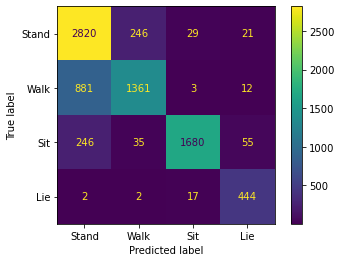

In [16]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_test, uy_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp = disp.plot()

#plt.savefig('confusion_matricies/c4_f113_km11+sw24_12.png') # number of classes, features, method
plt.show()